In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

In [127]:
from scipy.stats import norm

sigma = 10
cost = 1
# high value of planning: sigma=30, c=0.01
# medium value of planning: sigma=28, c=1.00
# low value of planning: sigma=1, c=4.00

def make_env(sigma=sigma, cost=cost, n=4):
    d = norm(0, sigma)
    vals = np.linspace(-1.5*sigma, 1.5*sigma, n)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    reward = Categorical(vals, probs)
    # vals = [-5, -1, 1, 5]
    # probs = [.1, .4, .4, .1]
    # reward = Categorical(vals, probs)
    return MouselabEnv([4,1,2], reward=reward, cost=cost,
                       ground_truth=[0, *reward.sample(16)])

def make_envs(seed=0, n=16):
    np.random.seed(seed)
    return [make_env() for _ in range(n)]

envs = make_envs(3)
TERM = envs[0].term_action

In [128]:
import json
def save_envs(envs):
    data = [{'stateRewards': e.ground_truth.tolist()} for e in envs]
    with open('../experiments/exp1/static/json/med_cost.json', 'w+') as f:
        json.dump(data, f)
        
save_envs(envs)

In [115]:
from policies import MouselabPolicy
from skopt import gp_minimize
bounds = [ (-30., 30.) ] * 4
agent = Agent()

def evaluate(policy, envs):
    def run_env(policy, env):
        agent.register(policy)
        agent.register(env)
        tr = agent.run_episode()
        return {'util': tr['return'],
                'observations': len(tr['actions']) - 1}
    return pd.DataFrame(run_env(policy, env) for env in envs)

def optimize(envs):    
    def objective(theta):
        theta = np.array(theta)
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        print(theta.round(3), util)
        return - util
    
    return gp_minimize(objective, bounds, n_calls=50, random_state=123)

In [116]:
agent = Agent()
result = optimize(envs)
print(np.array(result.x).round(3))

[ 11.788 -12.832 -16.389   3.079] 3.125
[ 13.168  -4.614  28.846  11.09 ] 14.9375
[ -1.144  -6.473  -9.409  13.743] 4.0
[ -3.686 -26.419  -6.117  14.28 ] 3.5625
[-19.05  -19.473   1.893   1.91 ] 3.125
[  8.064  20.966  13.467   6.661] 13.625
[ 13.347 -10.622  -8.293 -16.304] 3.125
[-12.377   7.859 -24.474  -3.978] 3.125
[ -4.148  -0.379  -4.45  -11.264] 3.125
[ -4.419  23.603  26.65    0.11 ] 13.5
[  8.064  20.966  13.467   6.661] 13.5
[ 13.124  -4.62   29.566   6.425] 14.9375
[ 30.  30.  30.  30.] 14.0
[ 30.     30.     23.606 -30.   ] 3.125
[ 14.309  -1.428  29.158   9.183] 15.1875
[ 30.     30.     24.941  11.292] 13.375
[ 14.472   7.954  28.995  10.071] 13.875
[ 11.114 -16.343  29.07    9.12 ] 14.1875
[-15.969  30.     19.846  16.263] 11.9375
[ 26.155  -5.575  30.      9.388] 14.9375
[ 21.699  -3.545  26.57    8.228] 14.9375
[ 30.     -2.132  30.     30.   ] 15.1875
[ 30.     -3.667  30.     30.   ] 14.9375
[ 30.     3.84  30.    30.  ] 13.75
[ 30.    -10.134  30.     29.243] 14.75

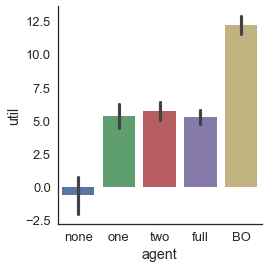

In [126]:
def data():
    policies = {
        'BO': MouselabPolicy(np.array([*result.x])),
        'full': FixedPlanPolicy(range(1, TERM+1)),
        'none': FixedPlanPolicy([TERM]),
        'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
        'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
    }
    def dfs():
        for name, policy in policies.items():
            df = evaluate(policy, envs=make_envs(3))
            df['agent'] = name
            # print('======= {} ======='.format(name))
            # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
            # print('Return: {:.3f}'.format(df.util.mean() / sigma))
            yield df
    return pd.concat(dfs())
    
df = data()
big_df = pd.concat([df] * 50)
sns.factorplot('agent', 'util', data=big_df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

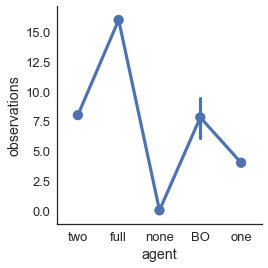

In [132]:
sns.factorplot('agent', 'observations', data=df)

In [47]:
util = df.groupby('agent').util
sem = util.std() / np.sqrt(50)
util.mean() / sem

agent
BO      5.333844
full    2.722179
none   -2.886751
one     1.233905
two     1.825742
Name: util, dtype: float64

In [12]:
def data():
    agent.register(env)
    policies = {
#         'BO': MouselabPolicy(np.array([*result.x])),
        'full': FixedPlanPolicy(range(1, TERM+1)),
        'none': FixedPlanPolicy([TERM]),
        'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
        'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
    }
    def dfs():
        for name, policy in policies.items():
            print(name)
            agent.register(policy)
            # df = pd.DataFrame(agent.run_many(100, pbar=0))
            
            df['agent'] = name
            print('======= {} ======='.format(name))
            print('Observations: {:.3f}'.format(df.n_steps.mean() - 2))
            print('Return: {:.3f}'.format(df['return'].mean() / sigma))
            yield df
    return pd.concat(dfs())
    
df = data()

NameError: name 'env' is not defined

In [ ]:
reward()
MouselabEnv([4,1,2], reward=reward(), cost=cost,
           ground_truth=)

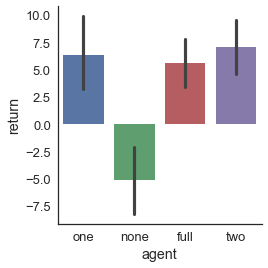

In [22]:
sns.factorplot('agent', 'return', data=df, 
               # order=['none', 'BO', 'full'], 
               kind='bar')

-2.2782142857142857

In [19]:
from policies import MouselabPolicy
agent = Agent()
env = MouselabEnv([4,1,2], reward=reward(), cost=0.01)
agent.register(env)
agent.register(FixedPlanPolicy(range(1, env.term_action+1)))
trace = agent.run_many(500)

In [21]:
np.mean(trace['return'])

2.1819999999999999